# 1.0 Setup and Dependencies
This section outlines the installation of necessary Python libraries and the import of specific modules required for the data analysis. Our primary tool, Cleanlab, will be utilized for advanced label consensus estimation, offering both a straightforward majority vote and a more refined linear regression-improved consensus label. For visualizing inter-annotator agreement, Seaborn will be employed to generate confusion matrices comparing the pairwise agreement between annotators (Annotator 1 vs. Annotator 2, Annotator 1 vs. Annotator 3, and Annotator 2 vs. Annotator 3). Additional utility libraries like openpyxl, nltk, and statsmodels are also installed and imported to support data loading, text preprocessing, and statistical analysis, respectively.

## 1.1 Install Required Libraries
Before commencing the data analysis, it's crucial to ensure all necessary Python libraries are installed within the environment. This step systematically installs core dependencies such as Cleanlab for advanced data quality assessment, Seaborn for statistical data visualization, Openpyxl for Excel file handling, NLTK for natural language processing utilities, and Statsmodels for comprehensive statistical modeling. By executing these installations upfront, we establish a robust and reproducible environment for the subsequent analysis.

In [ ]:
# Install core dependencies for data analysis and quality assessment
%pip install cleanlab
%pip install seaborn
%pip install openpyxl
%pip install nltk
%pip install statsmodels

## 1.2 Import All Necessary Libraries
With the required libraries successfully installed, this section centralizes all necessary import statements at the beginning of the notebook. This practice ensures that all modules and functions used throughout the analysis are readily available, promoting code clarity, preventing NameError exceptions during execution, and significantly enhancing the notebook's reproducibility. Essential libraries for data manipulation (Pandas, NumPy), text processing (re, NLTK), machine learning (Scikit-learn), data quality assessment (Cleanlab), statistical analysis (Statsmodels), and visualization (Matplotlib, Seaborn) are imported here. Additionally, specific NLTK data like stopwords are downloaded to support text preprocessing tasks.

In [ ]:
# Import all modules required for the entire analysis in one place.

import pandas as pd
import numpy as np
import re # Used for text cleaning in the TfidfVectorizer preprocessor
import json # Good for pretty-printing dictionary outputs (like health_summary)
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns

# Scikit-learn for machine learning utilities and metrics
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, cohen_kappa_score, accuracy_score # You use accuracy_score
from sklearn.preprocessing import LabelEncoder # Not directly used in the provided snippet but good to have if you later encode labels.

# Cleanlab for data quality and multi-annotator analysis
from cleanlab.dataset import health_summary
from cleanlab.filter import find_label_issues
from cleanlab.multiannotator import get_label_quality_multiannotator, get_majority_vote_label

# Statsmodels for statistical functions like Fleiss' Kappa
from statsmodels.stats.inter_rater import fleiss_kappa

# NLTK for natural language toolkit utilities (e.g., stopwords)
from nltk.corpus import stopwords # Specifically import stopwords from nltk.corpus
# Download NLTK data (like stopwords), typically done once
# This can remain here or be moved to just before its first use if you prefer,
# but at the beginning is fine as it's a common dependency.
import nltk
nltk.download('stopwords')

# For Path (though you only use pd.read_excel directly in your code,
# if you plan to use Path for more robust file paths, keep it)
from pathlib import Path

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
from google.colab import drive #import data from my drive
drive.mount('/drive')
path = '/drive/My Drive/Colab Notebooks/infotracer/'
print(f'Ruta del proyecto: {path}')

Mounted at /drive
Ruta del proyecto: /drive/My Drive/Colab Notebooks/infotracer/RESEARCH/


In [ ]:
# High-impact visual defaults
sns.set_theme(style="whitegrid", context="talk", palette="deep")

plt.rcParams.update({
    "figure.dpi": 160,
    "savefig.dpi": 300,
    "axes.titleweight": "bold",
    "axes.titlesize": 16,
    "axes.labelsize": 13,
    "xtick.labelsize": 11,
    "ytick.labelsize": 11,
    "legend.fontsize": 11
})

# Full-name mapping for legend
label_display = {
    "POS": "Positive",
    "NEG": "Negative",
    "NEU": "Neutral",
    "INDETERMINATE": "Indeterminate"
}

# Consistent color palette (keys MUST match hue values used in the plots)
palette_sent = {
    "Positive":      "#2C7BE5",  # harmonious blue
    "Negative":      "#E76F51",  # medium muted red
    "Neutral":       "#9AA0A6",  # gray
    "Indeterminate": "#F4D35E",  # amber (recommended)
}

# Consistent hue order
hue_order_full = ["Positive", "Negative", "Neutral", "Indeterminate"]


def _slugify(text: str) -> str:
    """Safe filename slug: lowercase, alphanumerics and underscores only."""
    text = text.strip().lower()
    text = re.sub(r"[^\w\s-]", "", text)
    text = re.sub(r"[\s-]+", "_", text)
    return text

def save_figure(fig, name: str, subdir: str = "figures/", dpi: int = 300, ext: str = "pdf"):
    """
    Save a Matplotlib figure as PNG with consistent, publication-ready settings.
    - fig: a Matplotlib Figure (e.g., returned by plt.figure() or ax.figure).
    - name: base filename (will be slugified, '.png' appended automatically).
    - subdir: output directory; created if missing.
    - dpi: export resolution.
    """
    # Normaliza y valida extensión
    ext = (ext or "pdf").strip(".").lower()
    if ext not in {"pdf", "png"}:
        raise ValueError("Parameter 'ext' must be 'pdf' or 'png'.")

    out_dir = Path(subdir)
    out_dir.mkdir(parents=True, exist_ok=True)

    fname = out_dir / f"{_slugify(name)}.{ext}"
    fig.savefig(
        fname,
        dpi=dpi,
        bbox_inches="tight",
        facecolor="white",
        transparent=False
    )
    print(f"[saved] {fname}")

## 1.3 Data Loading and Initial Preparation
This section focuses on loading the raw annotation data from the three individual annotators. The data, stored in Excel files, is read into separate Pandas DataFrames. Subsequently, these DataFrames are prepared for multi-annotator analysis by combining them into a single comprehensive DataFrame, which will serve as the primary dataset for all subsequent analyses, including consensus estimation and data quality assessment.

In [ ]:
# Load Excel files for each annotator
df1 = pd.read_excel(path+'data-labeled/annotator-1/sample-labeled-sentiment-anot1.xlsx')
df2 = pd.read_excel(path+'data-labeled/annotator-2/sample-labeled-sentiment-anot2.xlsx')
df3 = pd.read_excel(path+'data-labeled/annotator-3/sample-labeled-sentiment-anot3.xlsx')

print("--- Preview of Annotator 1 Data ---")
print(df1.head())
print("\n--- Preview of Annotator 2 Data ---")
print(df2.head())
print("\n--- Preview of Annotator 3 Data ---")
print(df3.head())

--- Preview of Annotator 1 Data ---
   platform                                               text  Sentiment
0  Facebook  La "gira de la transición" 🛩️🇲🇽 llevará a AMLO...          2
1  Facebook  Quienes apoyan a Xóchitl Gálvez muestran más g...          2
2  Facebook  Nuestra propuesta para hoy es esta bellísima c...          1
3  Facebook  hoy les traigo el debate del Presidente vs Jor...          2
4  Facebook  Que buen discurso \n\n#AndresManuelLopezObrado...          1

--- Preview of Annotator 2 Data ---
   platform                                               text  Sentiment
0  Facebook  La "gira de la transición" 🛩️🇲🇽 llevará a AMLO...          2
1  Facebook  Quienes apoyan a Xóchitl Gálvez muestran más g...          2
2  Facebook  Nuestra propuesta para hoy es esta bellísima c...          1
3  Facebook  hoy les traigo el debate del Presidente vs Jor...          2
4  Facebook  Que buen discurso \n\n#AndresManuelLopezObrado...          1

--- Preview of Annotator 3 Data ---
  

# 2.0 Estimating the Consensus of labels
This section calculates the consensus labels and creates an initial machine learning model using the raw data from the datasets. The consensus label is primarily derived using functionalities from the Cleanlab library, which offers robust methods for handling noisy labels and estimating true labels in multi-annotator settings.

## 2.1 Initial Data Preparation and Overview
To begin the multi-annotator analysis, the individual annotator DataFrames (df1, df2, df3) are first standardized by resetting their indices. Subsequently, these DataFrames are merged into a single, comprehensive DataFrame named combined_df. This consolidated DataFrame includes a unique ID for each text entry, the text itself, and the sentiment labels provided by each of the three annotators (A0001, A0002, A0003). This structure facilitates the subsequent calculations of inter-annotator agreement and consensus labels.

In [ ]:
# Ensure consistent index across all annotator DataFrames before combining
df1.reset_index(drop=True, inplace=True)
df2.reset_index(drop=True, inplace=True)
df3.reset_index(drop=True, inplace=True)

# Create a combined DataFrame with a unique ID and annotator labels
combined_df = pd.DataFrame({
    'ID': df1.index, # Use the reset index as a unique identifier
    'text': df1['text'],
    'A0001': df1['Sentiment'],
    'A0002': df2['Sentiment'],
    'A0003': df3['Sentiment'],
})

# Set the 'ID' column as the DataFrame's index for easier referencing
combined_df.set_index('ID', inplace=True)

# Display the first few rows of the combined DataFrame to verify structure
print("--- Preview of the Combined DataFrame ---")
print(combined_df.head())

# Display a few random text examples to get a qualitative sense of the data
print("\n--- Sample of Text Entries from the Combined Dataset ---")
print(combined_df['text'].sample(5, random_state=42).tolist())

# Confirm the total number of entries and the consistency across annotator columns
print(f"\nTotal number of text entries: {len(combined_df['text'])}")
print(f"Number of labels from Annotator A0001: {len(combined_df['A0001'])}")
print(f"Number of labels from Annotator A0002: {len(combined_df['A0002'])}")
print(f"Number of labels from Annotator A0003: {len(combined_df['A0003'])}")

--- Preview of the Combined DataFrame ---
                                                 text  A0001  A0002  A0003
ID                                                                        
0   La "gira de la transición" 🛩️🇲🇽 llevará a AMLO...      2      2      2
1   Quienes apoyan a Xóchitl Gálvez muestran más g...      2      2      2
2   Nuestra propuesta para hoy es esta bellísima c...      1      1      1
3   hoy les traigo el debate del Presidente vs Jor...      2      2      2
4   Que buen discurso \n\n#AndresManuelLopezObrado...      1      1      1

--- Sample of Text Entries from the Combined Dataset ---
['REGRESA LA MITOMANÍA DE XOCHITL GÁLVEZ AL SENADO DE LA REPÚBLICA!! LA PEOR CANDIDATA PRESIDENCIAL!! __ #ultimahora #notirafagatv #rafaherrera #Xochitl #xóchitlgálvez #ladybotarga', 'Acompañemos a su registro la doctora Claudia sheinbaum nuestra futura presidenta de la República.', 'AMLO servirá un deleite de platillos mexicanos en su ultima mañanera __ AMLO: Nada más les

## 2.2 Individual Annotator Label Distributions
To understand the labeling patterns of each annotator, the distribution of sentiment labels for Annotator 1 (A0001), Annotator 2 (A0002), and Annotator 3 (A0003) is visualized through histograms. These plots provide insights into the frequency of each sentiment class (0, 1, 2) assigned by individual annotators, revealing potential biases or differences in their labeling tendencies. Alongside the visualizations, the raw and normalized value counts for each annotator's labels are printed to provide precise quantitative summaries.

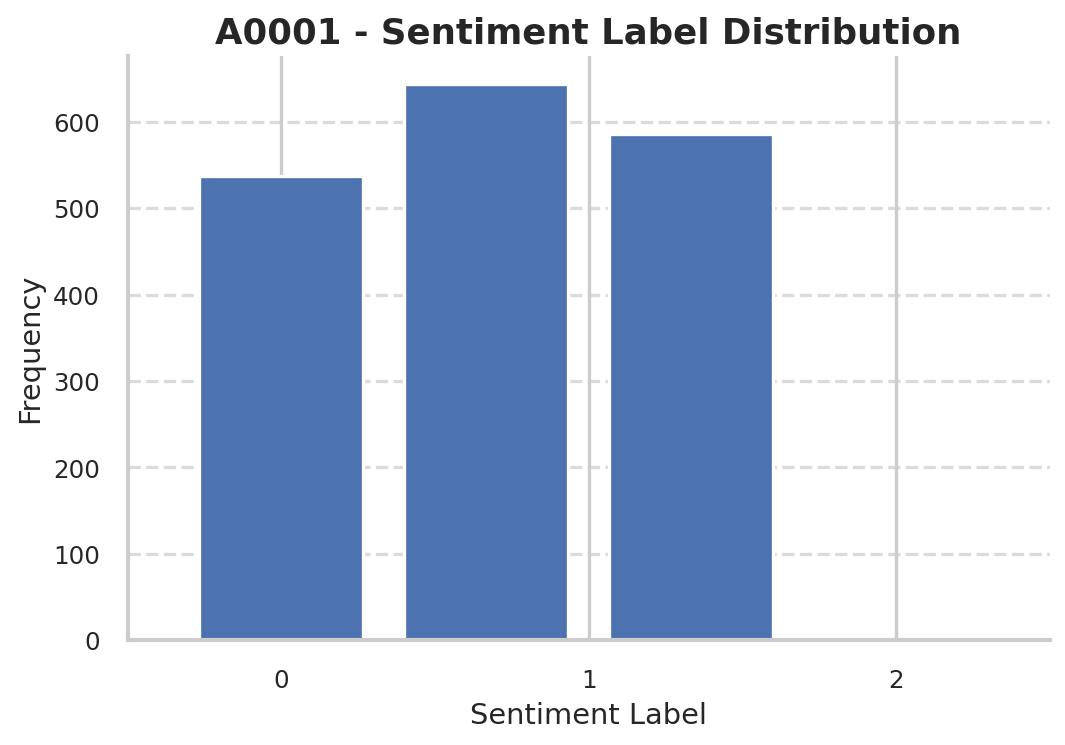

--- Value Counts for Annotator A0001 ---
A0001
1    644
2    586
0    537
Name: count, dtype: int64

--- Normalized Value Counts for Annotator A0001 ---
A0001
1    0.364460
2    0.331636
0    0.303905
Name: proportion, dtype: float64


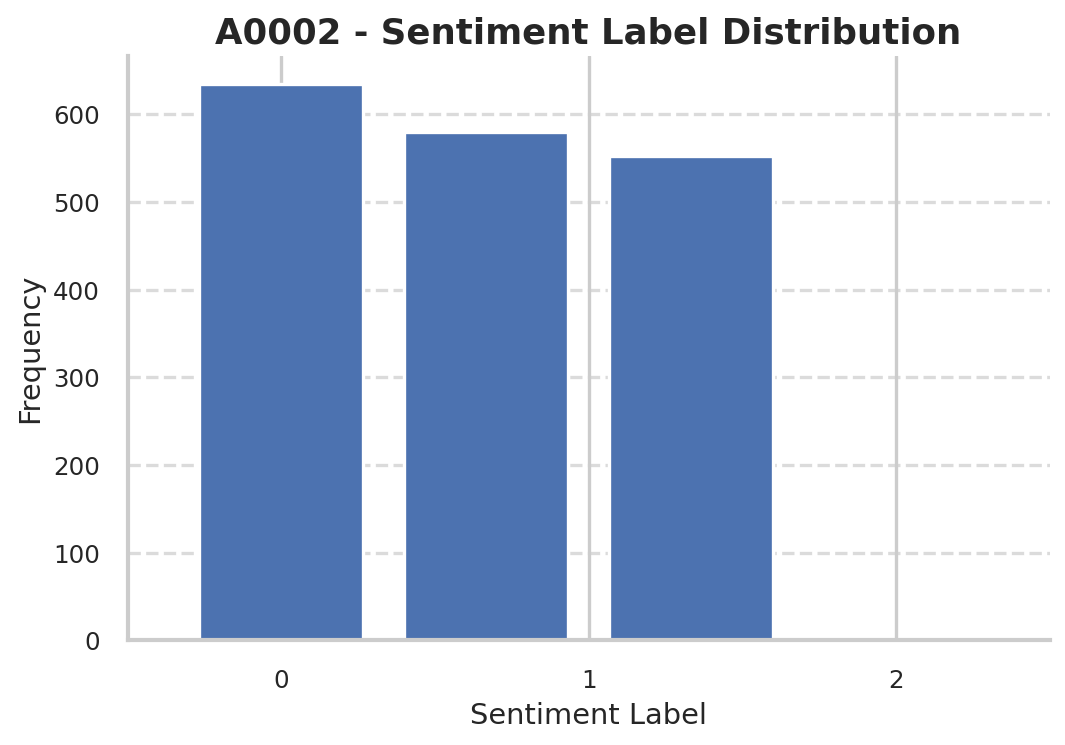


--- Value Counts for Annotator A0002 ---
A0002
0    635
1    580
2    552
Name: count, dtype: int64

--- Normalized Value Counts for Annotator A0002 ---
A0002
0    0.359366
1    0.328240
2    0.312394
Name: proportion, dtype: float64


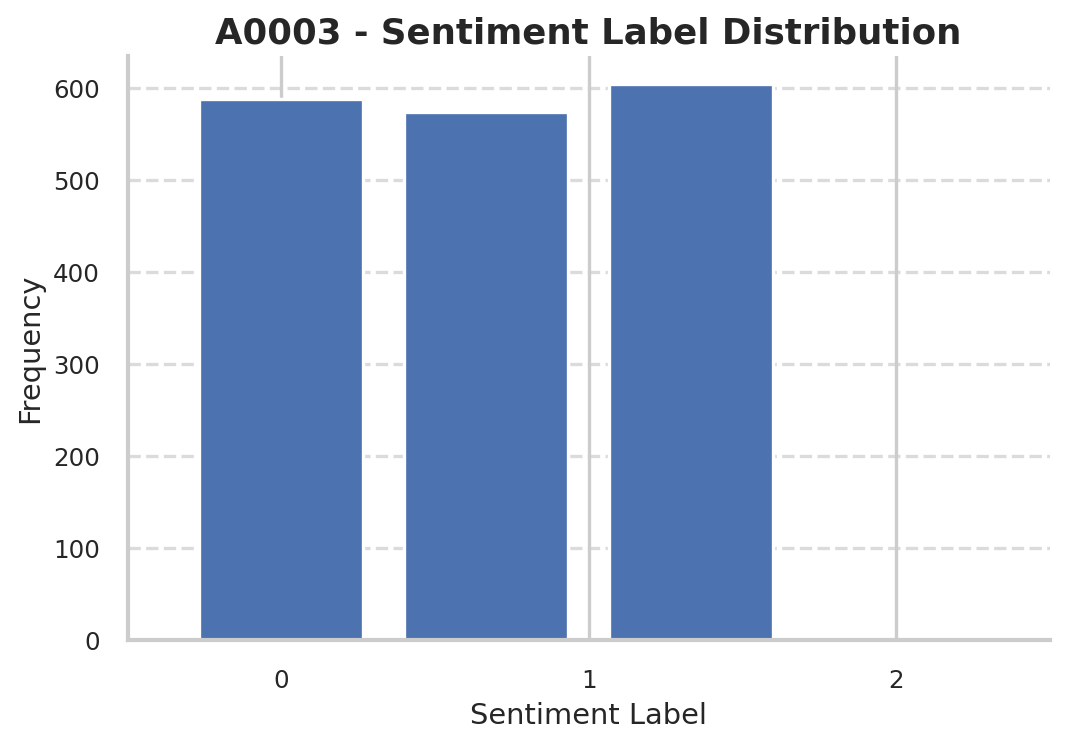


--- Value Counts for Annotator A0003 ---
A0003
2    605
0    588
1    574
Name: count, dtype: int64

--- Normalized Value Counts for Annotator A0003 ---
A0003
2    0.342388
0    0.332767
1    0.324844
Name: proportion, dtype: float64


In [ ]:
# Plotting the histogram for Annotator 1's sentiment labels
plt.figure(figsize=(7, 5)) # Set figure size for better aesthetics
combined_df['A0001'].plot(kind='hist', bins=3, title='A0001 - Sentiment Label Distribution', align='left', rwidth=0.8)
plt.xlim(-0.5, 2.5) # Limits x-axis to clearly show 0, 1, 2
plt.xticks([0, 1, 2]) # Sets ticks to only 0, 1, 2
plt.xlabel("Sentiment Label")
plt.ylabel("Frequency")
plt.gca().spines[['top', 'right']].set_visible(False) # Remove unnecessary chart borders
plt.grid(axis='y', linestyle='--', alpha=0.7) # Add a subtle grid for readability
plt.tight_layout() # Adjust layout to prevent labels from overlapping
plt.show()

print("--- Value Counts for Annotator A0001 ---")
print(combined_df['A0001'].value_counts())
print("\n--- Normalized Value Counts for Annotator A0001 ---")
print(combined_df['A0001'].value_counts(normalize=True))

# Plotting the histogram for Annotator 2's sentiment labels
plt.figure(figsize=(7, 5))
combined_df['A0002'].plot(kind='hist', bins=3, title='A0002 - Sentiment Label Distribution', align='left', rwidth=0.8)
plt.xlim(-0.5, 2.5)
plt.xticks([0, 1, 2])
plt.xlabel("Sentiment Label")
plt.ylabel("Frequency")
plt.gca().spines[['top', 'right']].set_visible(False)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

print("\n--- Value Counts for Annotator A0002 ---")
print(combined_df['A0002'].value_counts())
print("\n--- Normalized Value Counts for Annotator A0002 ---")
print(combined_df['A0002'].value_counts(normalize=True))

# Plotting the histogram for Annotator 3's sentiment labels
plt.figure(figsize=(7, 5))
combined_df['A0003'].plot(kind='hist', bins=3, title='A0003 - Sentiment Label Distribution', align='left', rwidth=0.8)
plt.xlim(-0.5, 2.5)
plt.xticks([0, 1, 2])
plt.xlabel("Sentiment Label")
plt.ylabel("Frequency")
plt.gca().spines[['top', 'right']].set_visible(False)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Note: The original code mistakenly printed A0001 counts again here.
# Correcting to print A0003 counts for consistency.
print("\n--- Value Counts for Annotator A0003 ---")
print(combined_df['A0003'].value_counts())
print("\n--- Normalized Value Counts for Annotator A0003 ---")
print(combined_df['A0003'].value_counts(normalize=True))

## 2.3 Pairwise Annotator Agreement: Confusion Matrices
To visually assess the agreement and disagreement patterns between pairs of annotators, confusion matrices are generated. Each matrix displays how often one annotator assigned a particular label compared to another annotator for the same item. This provides a detailed breakdown of concordant and discordant labels, highlighting specific classes where annotators might have consistent disagreements.

--- Generating Pairwise Confusion Matrices ---


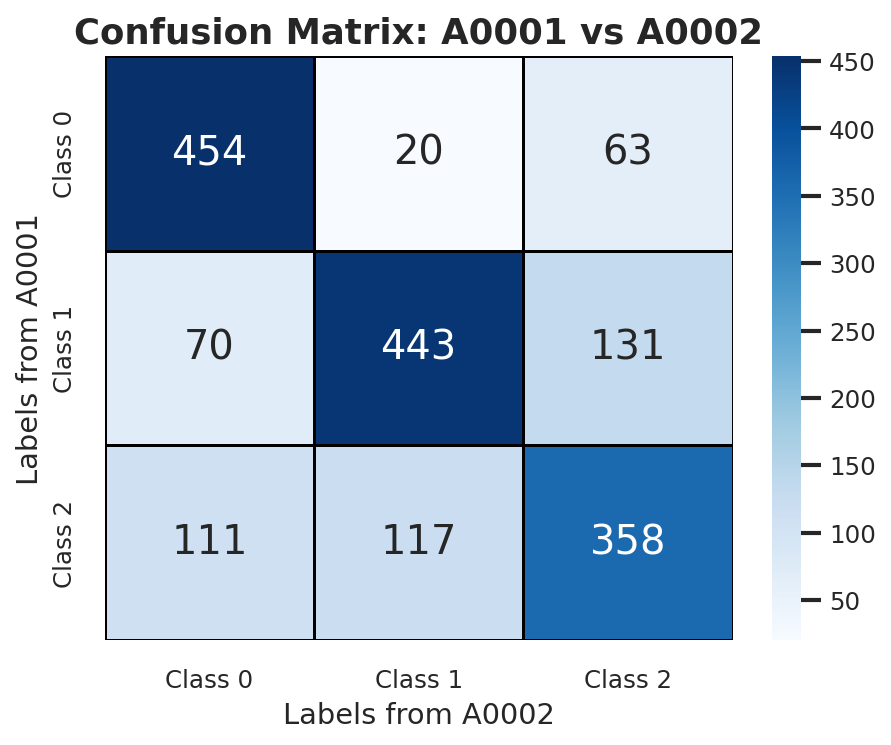

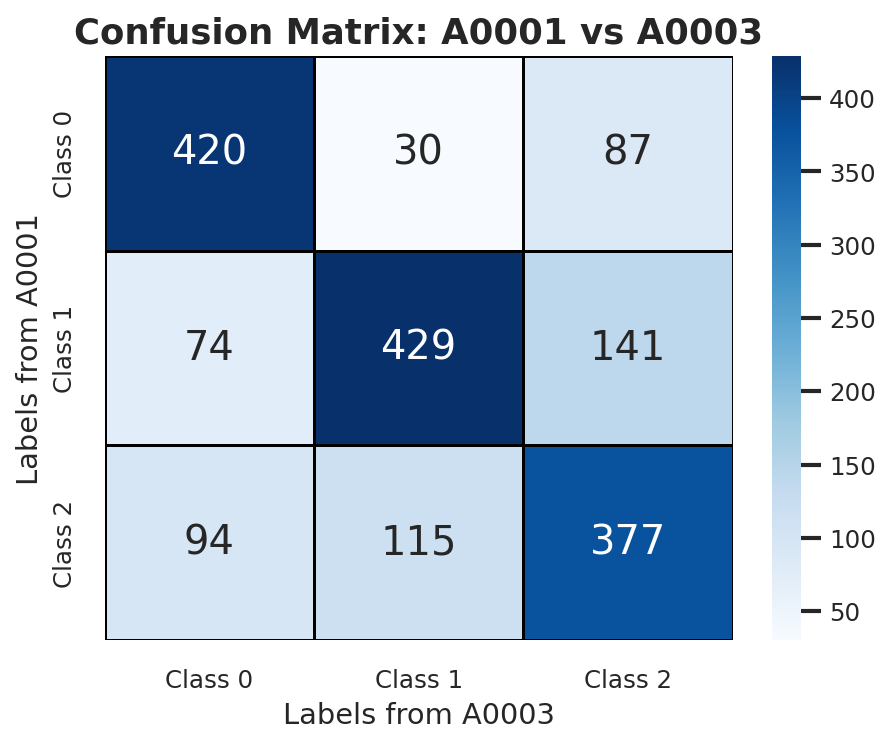

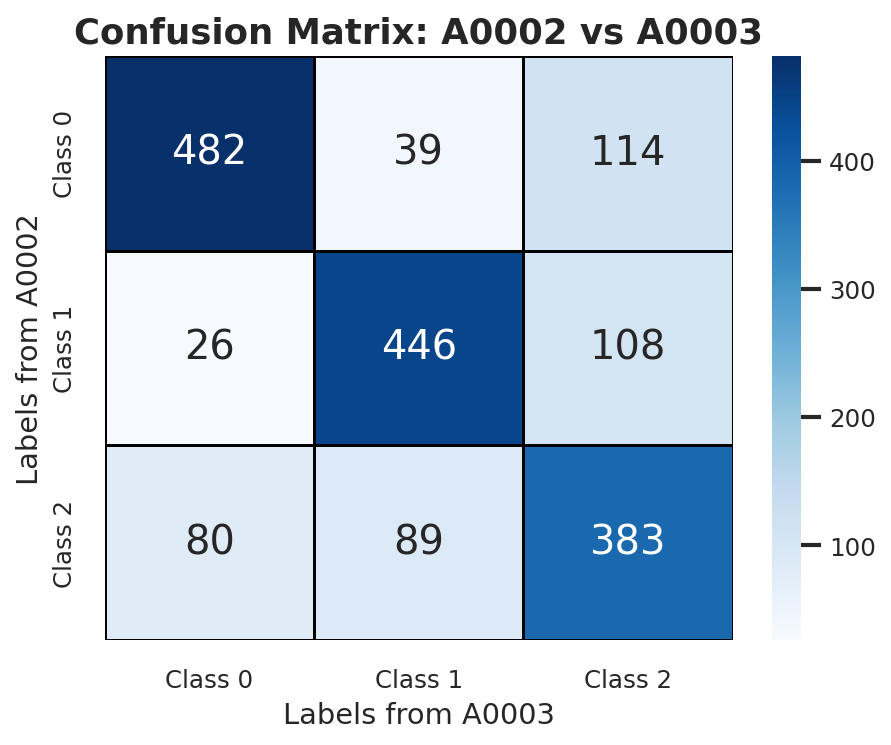

In [ ]:
# Function to plot a confusion matrix, now defined once and used for all pairs
def plot_confusion_matrix(cm, annotator_pair):
    # Determine all possible labels dynamically from the combined data
    labels = sorted(set(combined_df[['A0001', 'A0002', 'A0003']].values.ravel()))
    plt.figure(figsize=(6, 5)) # Adjusted figure size for better visualization
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True,
                xticklabels=[f'Class {l}' for l in labels],
                yticklabels=[f'Class {l}' for l in labels],
                linewidths=.5, linecolor='black') # Added lines for better separation
    plt.xlabel(f'Labels from {annotator_pair.split(" vs ")[1]}')
    plt.ylabel(f'Labels from {annotator_pair.split(" vs ")[0]}')
    plt.title(f'Confusion Matrix: {annotator_pair}')
    plt.tight_layout()
    plt.show()

print("--- Generating Pairwise Confusion Matrices ---")

# Confusion Matrix between Annotator A0001 and A0002
cm_1_2 = confusion_matrix(combined_df['A0001'], combined_df['A0002'])
plot_confusion_matrix(cm_1_2, 'A0001 vs A0002')

# Confusion Matrix between Annotator A0001 and A0003
cm_1_3 = confusion_matrix(combined_df['A0001'], combined_df['A0003'])
plot_confusion_matrix(cm_1_3, 'A0001 vs A0003')

# Confusion Matrix between Annotator A0002 and A0003
cm_2_3 = confusion_matrix(combined_df['A0002'], combined_df['A0003'])
plot_confusion_matrix(cm_2_3, 'A0002 vs A0003')

## 2.4 Consensus Label via Majority Vote
The simplest method for deriving a single consensus label from multiple annotators is the majority vote. For each data instance, the label assigned by the majority of annotators is selected as the consensus. In cases of ties, cleanlab's get_majority_vote_label function handles the resolution (e.g., by selecting the label with the smallest index). This consensus label serves as a baseline "ground truth" for initial model training and further quality assessment.

In [ ]:
# Extract annotations from the relevant columns for majority vote calculation
annotations = combined_df[['A0001', 'A0002', 'A0003']].values

# Compute the majority vote label for each instance using Cleanlab's utility
majority_vote_label = get_majority_vote_label(annotations)

# Store the newly computed majority vote labels in the combined DataFrame
combined_df['majority_vote_label'] = majority_vote_label

# Display the first few rows showing original annotations and the new majority vote label
print("--- Annotator Labels and Majority Vote Consensus ---")
print(combined_df[['A0001', 'A0002', 'A0003', 'majority_vote_label']].head())

--- Annotator Labels and Majority Vote Consensus ---
    A0001  A0002  A0003  majority_vote_label
ID                                          
0       2      2      2                    2
1       2      2      2                    2
2       1      1      1                    1
3       2      2      2                    2
4       1      1      1                    1


## 2.5 Text Vectorization and Initial Model Training
To enable machine learning analysis, the raw text data must first be converted into a numerical feature representation. This is achieved using TfidfVectorizer, which transforms text into TF-IDF (Term Frequency-Inverse Document Frequency) features, capturing the importance of words within documents relative to the entire corpus. A custom clean_text preprocessor is applied to remove noise like URLs, mentions, hashtags, and non-alphanumeric characters. These vectorized features (X) are then used to train a Logistic Regression model, which serves as a baseline classifier. Cross-validation is employed to generate out-of-sample predicted probabilities (pred_probs), essential for Cleanlab's label quality assessment.

In [ ]:
# Custom preprocessor function to clean text before vectorization
def clean_text(text):
    text = str(text).lower() # Ensure text is string and convert to lowercase
    text = re.sub(r'http\S+', '', text) # Remove URLs
    text = re.sub(r'@\w+', '', text) # Remove mentions
    text = re.sub(r'#\w+', '', text) # Remove hashtags
    text = re.sub(r'[^\w\s]', '', text) # Remove punctuation and special characters
    text = re.sub(r'\d+', '', text) # Remove numbers
    text = re.sub(r'\s+', ' ', text).strip() # Replace multiple spaces with single space and strip whitespace
    return text

# Download Spanish stopwords if not already available (handled in Section 1.2)
# nltk.download('stopwords') # This line is redundant if already in 1.2
spanish_stopwords = stopwords.words('spanish')

# Initialize TfidfVectorizer with specified parameters and custom preprocessor
vectorizer = TfidfVectorizer(
    max_features=5000, # Limit to top 5000 features
    ngram_range=(1, 2), # Consider unigrams and bigrams
    preprocessor=clean_text, # Apply custom cleaning function
    stop_words=spanish_stopwords # Remove common Spanish stopwords
)

# Fit the vectorizer and transform the 'text' column of the combined DataFrame
X = vectorizer.fit_transform(combined_df['text'])

print("--- Text Vectorization Results ---")
print(f"Shape of the vectorized feature matrix (X): {X.shape}") # e.g., (1767, 5000) → 1767 texts, 5000 features

# Use the majority vote labels as the target variable for the baseline model
y_majority = combined_df['majority_vote_label']

# Initialize and train a Logistic Regression model with cross-validation
# max_iter is increased to ensure convergence for larger datasets
model = LogisticRegression(max_iter=1000, random_state=42) # Added random_state for reproducibility

# Generate out-of-sample predicted probabilities using cross-validation
# These probabilities are crucial for Cleanlab's label quality assessment
pred_probs = cross_val_predict(model, X, y_majority, cv=5, method='predict_proba')

print(f"Shape of predicted probabilities (pred_probs): {pred_probs.shape}")

# Extract the annotations matrix for Cleanlab's multi-annotator analysis
annotations = combined_df[['A0001', 'A0002', 'A0003']].values

# Use Cleanlab's get_label_quality_multiannotator to assess label quality
# and derive a more refined consensus label based on model predictions
print("\n--- Cleanlab's Multi-Annotator Label Quality Assessment (Initial) ---")
results = get_label_quality_multiannotator(
    labels_multiannotator=annotations,
    pred_probs=pred_probs,
    verbose=True # Displays progress and summary during computation
)

print("\n--- Initial Consensus Label Quality (Head) ---")
print(results["label_quality"].head())

print("\n--- Initial Detailed Label Quality per Annotator (Head) ---")
print(results["detailed_label_quality"].head())

print("\n--- Initial Annotator Statistics (Top 10) ---")
print(results["annotator_stats"].head(10))

# Store the improved consensus label derived from Cleanlab's analysis
improved_consensus_label = results["label_quality"]["consensus_label"].values

--- Text Vectorization Results ---
Shape of the vectorized feature matrix (X): (1767, 5000)
Shape of predicted probabilities (pred_probs): (1767, 3)

--- Cleanlab's Multi-Annotator Label Quality Assessment (Initial) ---

--- Initial Consensus Label Quality (Head) ---
   consensus_label  consensus_quality_score  annotator_agreement  \
0                2                 0.715468                  1.0   
1                2                 0.663362                  1.0   
2                1                 0.727292                  1.0   
3                2                 0.692969                  1.0   
4                1                 0.684049                  1.0   

   num_annotations  
0                3  
1                3  
2                3  
3                3  
4                3  

--- Initial Detailed Label Quality per Annotator (Head) ---
   quality_annotator_0  quality_annotator_1  quality_annotator_2
0             0.715468             0.715468             0.715468
1     

## 2.6 Comparing Consensus Label Accuracies
Since a true ground-truth dataset is unavailable, the quality of the two derived consensus labeling approaches—simple majority vote and Cleanlab's model-assisted consensus labels—is indirectly evaluated by training separate Logistic Regression models. For each set of consensus labels, a model is trained using cross-validation on the vectorized text features, and its classification accuracy is computed. This comparison provides a proxy for label quality, indicating which consensus method yields a more predictable and consistent label set from the input features.

In [ ]:
print("--- Comparing Accuracy of Majority Vote vs. Cleanlab Consensus Labels ---")

# Train and evaluate a Logistic Regression model using Majority Vote labels
y_majority = combined_df['majority_vote_label']
model_majority = LogisticRegression(max_iter=1000, random_state=42)
y_pred_majority = cross_val_predict(model_majority, X, y_majority, cv=5)
accuracy_majority = accuracy_score(y_majority, y_pred_majority)

# Train and evaluate a Logistic Regression model using Cleanlab's Consensus labels
y_cleanlab = results["label_quality"]["consensus_label"].values
model_cleanlab = LogisticRegression(max_iter=1000, random_state=42)
y_pred_cleanlab = cross_val_predict(model_cleanlab, X, y_cleanlab, cv=5)
accuracy_cleanlab = accuracy_score(y_cleanlab, y_pred_cleanlab)

# Display the classification accuracies for both consensus methods
print(f"Accuracy of majority vote labels = {accuracy_majority:.4f}")
print(f"Accuracy of cleanlab consensus labels = {accuracy_cleanlab:.4f}")

--- Comparing Accuracy of Majority Vote vs. Cleanlab Consensus Labels ---
Accuracy of majority vote labels = 0.6197
Accuracy of cleanlab consensus labels = 0.6593


# 3.0 Health Summary and Analysis of Label Issues
This section delves into assessing and improving the quality of the annotated dataset using Cleanlab. We begin by generating a health summary to identify potential label issues within the initial consensus labels. Based on this analysis, we then undertake a process to clean up rows with identified issues, aiming to create a more robust dataset. Finally, we re-evaluate the dataset's health summary with the refined labels to demonstrate the impact of our data cleaning efforts, aiming for higher overall label quality.

## 3.1 Initial Dataset Health Summary
To evaluate the overall quality of our raw dataset, we utilize Cleanlab's health_summary function. This function takes the derived consensus labels (from Section 2.1.3) and the predicted probabilities from our baseline Logistic Regression model to assess various aspects of label quality, including potential label noise, inverse label noise, and class overlap. This initial summary provides crucial insights into the reliability of our annotations and pinpoints areas requiring attention.

In [ ]:
# Use the consensus labels (from 2.1.3) and the predicted probabilities
labels = results["label_quality"]["consensus_label"].values

# Generate the health summary for the initial dataset
print("--- Generating Initial Dataset Health Summary ---")
summary = health_summary(labels=labels, pred_probs=pred_probs)

--- Generating Initial Dataset Health Summary ---
----------------------------------------------------------
|  Generating a Cleanlab Dataset Health Summary          |
|   for your dataset with 1,767 examples and 3 classes.  |
|  Note, Cleanlab is not a medical doctor... yet.        |
----------------------------------------------------------

Overall Class Quality and Noise across your dataset (below)
------------------------------------------------------------ 



,Class Index,Label Issues,Inverse Label Issues,Label Noise,Inverse Label Noise,Label Quality Score
0,1,168,101,0.295775,0.201597,0.704225
1,2,156,239,0.268966,0.360483,0.731034
2,0,139,123,0.224556,0.203980,0.775444



Class Overlap. In some cases, you may want to merge classes in the top rows (below)
-----------------------------------------------------------------------------------



,Class Index A,Class Index B,Num Overlapping Examples,Joint Probability
0,1,2,201,0.113752
1,0,2,194,0.109791
2,0,1,68,0.038483



 * Overall, about 17% (298 of the 1,767) labels in your dataset have potential issues.
 ** The overall label health score for this dataset is: 0.83.

Generated with <3 from Cleanlab.



## 3.2 Identifying and Cleaning Label Issues
Following the initial health summary, we proceed to identify specific data points with potential label issues. Cleanlab's find_label_issues function is employed for this purpose, leveraging the predicted probabilities and consensus labels to detect potentially mislabeled examples. Once identified, these problematic rows are removed from the combined_df to create a cleaned_combined_df. This step is crucial for mitigating noise and improving the overall integrity of our dataset.

In [ ]:
# Use find_label_issues to get indices of examples with potential issues
# 'self_confidence' ranks issues by how confident the model is in the true label
# versus the given label.
issue_indices = find_label_issues(
    labels=labels, # Use the consensus labels as the "noisy" labels for Cleanlab
    pred_probs=pred_probs,
    return_indices_ranked_by="self_confidence"
)

# Create a new DataFrame by dropping the identified problematic rows
cleaned_combined_df = combined_df.drop(index=issue_indices)

# Optionally, remove the corresponding labels if you were working with a separate label array
# cleaned_labels = np.delete(labels, issue_indices) # This line is commented as it's not directly used later
                                                   # but useful for concept illustration.

print(f"\n--- Label Issue Identification Results ---")
print(f"Total examples in original dataset: {len(combined_df)}")
print(f"Number of examples identified with potential issues: {len(issue_indices)}")
print(f"Number of examples in cleaned dataset: {len(cleaned_combined_df)}")

print("\n--- Preview of Cleaned Combined DataFrame ---")
print(cleaned_combined_df.head())


--- Label Issue Identification Results ---
Total examples in original dataset: 1767
Number of examples identified with potential issues: 413
Number of examples in cleaned dataset: 1354

--- Preview of Cleaned Combined DataFrame ---
                                                 text  A0001  A0002  A0003  \
ID                                                                           
0   La "gira de la transición" 🛩️🇲🇽 llevará a AMLO...      2      2      2   
2   Nuestra propuesta para hoy es esta bellísima c...      1      1      1   
3   hoy les traigo el debate del Presidente vs Jor...      2      2      2   
4   Que buen discurso \n\n#AndresManuelLopezObrado...      1      1      1   
5   . 🚴✖️🔴 en Washington 🇺🇸 lunes 5 de febrero Lle...      2      2      2   

    majority_vote_label  
ID                       
0                     2  
2                     1  
3                     2  
4                     1  
5                     2  


## 3.3 Re-computing Majority Vote and Retraining Model on Cleaned Data
After cleaning the dataset, it's essential to re-establish the majority vote consensus and retrain our baseline Logistic Regression model on this improved data. This ensures that the subsequent label quality assessment reflects the enhanced dataset. The text features are re-vectorized from the cleaned_combined_df, and new out-of-sample predicted probabilities are generated, forming the basis for the refined Cleanlab analysis.

In [ ]:
# Extract annotations from the cleaned DataFrame for majority vote calculation
annotations_cleaned = cleaned_combined_df[['A0001', 'A0002', 'A0003']].values

# Compute the majority vote label for the cleaned dataset
cleaned_combined_df['majority_vote_label'] = get_majority_vote_label(annotations_cleaned)

print("\n--- Majority Vote Consensus on Cleaned Data (Head) ---")
print(cleaned_combined_df[['A0001', 'A0002', 'A0003', 'majority_vote_label']].head())

# Re-vectorize text from the cleaned DataFrame
# It's important to refit_transform on the cleaned text to get features for the new dataset
X_cleaned = vectorizer.fit_transform(cleaned_combined_df['text'])
print(f"\nShape of vectorized features for cleaned data (X_cleaned): {X_cleaned.shape}")

# Use the new majority vote labels from the cleaned data as the target variable
y_majority_cleaned = cleaned_combined_df['majority_vote_label']

# Retrain the logistic regression model and generate new predicted probabilities on cleaned data
print("\n--- Retraining Logistic Regression Model on Cleaned Data ---")
model_cleaned = LogisticRegression(max_iter=1000, random_state=42)
pred_probs_cleaned = cross_val_predict(model_cleaned, X_cleaned, y_majority_cleaned, cv=5, method='predict_proba')
print(f"Shape of predicted probabilities for cleaned data (pred_probs_cleaned): {pred_probs_cleaned.shape}")


--- Majority Vote Consensus on Cleaned Data (Head) ---
    A0001  A0002  A0003  majority_vote_label
ID                                          
0       2      2      2                    2
2       1      1      1                    1
3       2      2      2                    2
4       1      1      1                    1
5       2      2      2                    2

Shape of vectorized features for cleaned data (X_cleaned): (1354, 5000)

--- Retraining Logistic Regression Model on Cleaned Data ---
Shape of predicted probabilities for cleaned data (pred_probs_cleaned): (1354, 3)


## 3.4 Re-evaluating Dataset Health Summary
With the cleaned dataset and the retrained model, we perform a second health_summary analysis. This step is critical to quantify the impact of our data cleaning efforts. We expect to see an improvement in the overall label health score, a reduction in the percentage of labels with issues, and potentially clearer class distinctions, confirming the effectiveness of addressing the identified noisy examples.

In [ ]:
# Extract annotations from the cleaned combined DataFrame for Cleanlab's multi-annotator analysis
annotations_cleaned = cleaned_combined_df[['A0001', 'A0002', 'A0003']].values

# Re-run Cleanlab's get_label_quality_multiannotator on the cleaned data
print("\n--- Cleanlab's Multi-Annotator Label Quality Assessment (Cleaned Data) ---")
results_cleaned = get_label_quality_multiannotator(
    labels_multiannotator=annotations_cleaned,
    pred_probs=pred_probs_cleaned,
    verbose=True
)

# Extract the new consensus labels derived from the cleaned data
labels_cleaned = results_cleaned["label_quality"]["consensus_label"].values

# Generate the health summary for the cleaned dataset
print("\n--- Generating Cleaned Dataset Health Summary ---")
summary_cleaned = health_summary(labels=labels_cleaned, pred_probs=pred_probs_cleaned)


--- Cleanlab's Multi-Annotator Label Quality Assessment (Cleaned Data) ---

--- Generating Cleaned Dataset Health Summary ---
----------------------------------------------------------
|  Generating a Cleanlab Dataset Health Summary          |
|   for your dataset with 1,354 examples and 3 classes.  |
|  Note, Cleanlab is not a medical doctor... yet.        |
----------------------------------------------------------

Overall Class Quality and Noise across your dataset (below)
------------------------------------------------------------ 



,Class Index,Label Issues,Inverse Label Issues,Label Noise,Inverse Label Noise,Label Quality Score
0,1,16,0,0.037825,0.000000,0.962175
1,0,17,16,0.034413,0.032454,0.965587
2,2,4,21,0.009153,0.046256,0.990847



Class Overlap. In some cases, you may want to merge classes in the top rows (below)
-----------------------------------------------------------------------------------



,Class Index A,Class Index B,Num Overlapping Examples,Joint Probability
0,0,2,21,0.015510
1,0,1,12,0.008863
2,1,2,4,0.002954



 * Overall, about 1% (18 of the 1,354) labels in your dataset have potential issues.
 ** The overall label health score for this dataset is: 0.99.

Generated with <3 from Cleanlab.



## 3.5 Final Cleaned Dataset with Consensus Labels
To finalize this section, the improved consensus labels derived from the analysis of the cleaned dataset are added to the cleaned_combined_df. This resulting DataFrame, cln_combined_df, represents our refined dataset ready for further analysis or model training, benefiting from the removal of identified label issues and a more robust consensus estimation. The majority_vote_label column is removed to keep only the most refined consensus.

In [ ]:
# Copy the cleaned_combined_df to a new variable for the final dataset
cln_combined_df = cleaned_combined_df.copy()

# Add the improved consensus labels to the final DataFrame
cln_combined_df['consensus_label'] = labels_cleaned

# Remove the temporary 'majority_vote_label' column as it's superseded by the new consensus
cln_combined_df.drop(columns=['majority_vote_label'], inplace=True)

print("\n--- Final Cleaned DataFrame with Improved Consensus Labels (Head) ---")
print(cln_combined_df.head())


--- Final Cleaned DataFrame with Improved Consensus Labels (Head) ---
                                                 text  A0001  A0002  A0003  \
ID                                                                           
0   La "gira de la transición" 🛩️🇲🇽 llevará a AMLO...      2      2      2   
2   Nuestra propuesta para hoy es esta bellísima c...      1      1      1   
3   hoy les traigo el debate del Presidente vs Jor...      2      2      2   
4   Que buen discurso \n\n#AndresManuelLopezObrado...      1      1      1   
5   . 🚴✖️🔴 en Washington 🇺🇸 lunes 5 de febrero Lle...      2      2      2   

    consensus_label  
ID                   
0                 2  
2                 1  
3                 2  
4                 1  
5                 2  


# 4.0 Calculating Metrics in the Final Dataset
This section focuses on quantifying the inter-annotator agreement within the refined dataset. We'll compute and visualize Cohen's Kappa for pairwise annotator agreement, offering insights into the consistency between individual annotator pairs. Subsequently, Fleiss' Kappa will be calculated to assess the overall agreement among all three annotators. These metrics provide robust statistical evidence of the reliability and quality of the finalized sentiment labels.

## 4.1 Cohen's Kappa

### 4.1.1 Compute Cohen's Kappa Scores
To gain a granular understanding of the agreement between each pair of annotators, Cohen's Kappa (κ) is computed. This statistical measure accounts for the agreement occurring by chance, providing a more robust indicator of inter-rater reliability than simple percentage agreement. We calculate κ for Annotator 1 vs. Annotator 2, Annotator 1 vs. Annotator 3, and Annotator 2 vs. Annotator 3 using the labels from our cleaned dataset.


In [ ]:
# Compute Cohen's Kappa for each annotator pair using the cleaned dataset
print("--- Calculating Pairwise Cohen's Kappa Scores ---")

# Kappa between Annotator A0001 and A0002
cks_1_2 = cohen_kappa_score(cln_combined_df['A0001'], cln_combined_df['A0002'])
print(f"Cohen's Kappa (A0001 vs A0002): {cks_1_2:.3f}")

# Kappa between Annotator A0001 and A0003
cks_1_3 = cohen_kappa_score(cln_combined_df['A0001'], cln_combined_df['A0003'])
print(f"Cohen's Kappa (A0001 vs A0003): {cks_1_3:.3f}")

# Kappa between Annotator A0002 and A0003
cks_2_3 = cohen_kappa_score(cln_combined_df['A0002'], cln_combined_df['A0003'])
print(f"Cohen's Kappa (A0002 vs A0003): {cks_2_3:.3f}")

--- Calculating Pairwise Cohen's Kappa Scores ---
Cohen's Kappa (A0001 vs A0002): 0.578
Cohen's Kappa (A0001 vs A0003): 0.584
Cohen's Kappa (A0002 vs A0003): 0.663


### 4.1.2 Visualize Pairwise Cohen’s Kappa as Heatmap
To provide a quick and intuitive visual summary of the pairwise agreement, a heatmap is generated from the calculated Cohen's Kappa scores. This visualization clearly displays the reliability levels across all annotator pairings, with values ranging from 0 (no agreement beyond chance) to 1 (perfect agreement). The diagonal elements are set to 1.0, representing each annotator's perfect agreement with themselves.

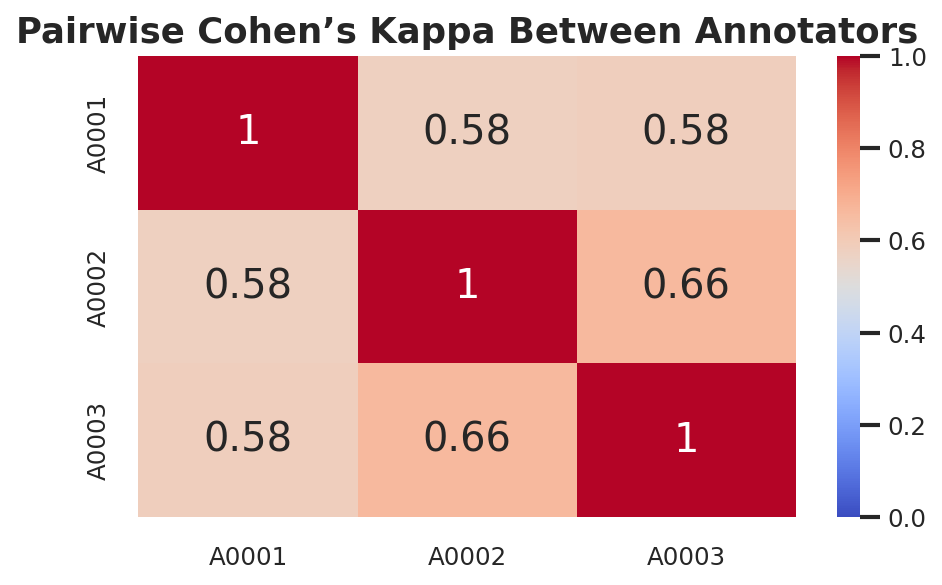

In [ ]:
# Compute pairwise Cohen’s Kappa
annotators = ['A0001', 'A0002', 'A0003']
kappa_matrix = pd.DataFrame(index=annotators, columns=annotators, dtype=float)

for i in annotators:
    for j in annotators:
        if i == j:
            kappa_matrix.loc[i, j] = 1.0
        else:
            kappa_matrix.loc[i, j] = cohen_kappa_score(cln_combined_df[i], cln_combined_df[j])

# Plot heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(kappa_matrix, annot=True, cmap='coolwarm', vmin=0, vmax=1)
plt.title("Pairwise Cohen’s Kappa Between Annotators")
plt.tight_layout()
plt.show()

[saved] /drive/My Drive/Colab Notebooks/infotracer/RESEARCH/figs_annot/cohen_kappa_between_annot_sent.pdf
[saved] /drive/My Drive/Colab Notebooks/infotracer/RESEARCH/figs_annot/cohen_kappa_between_annot_sent.png


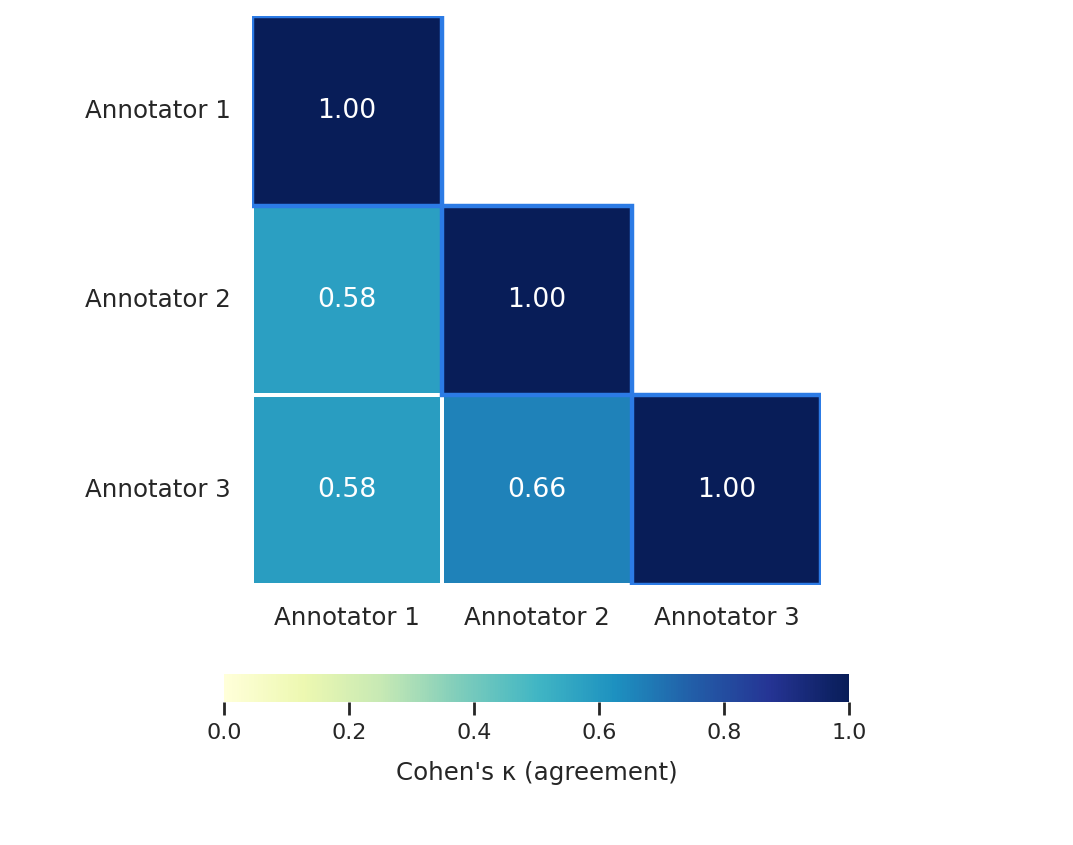

In [ ]:
# Pairwise Cohen's Kappa — Heatmap estilizado (rótulos "Annotator 1", ...)

# 1) Defina os anotadores originais (ajuste se necessário)
annotators = ['A0001', 'A0002', 'A0003']

# 1b) Mapeamento para nomes de exibição
display_names = {a: f"Annotator {i+1}" for i, a in enumerate(annotators)}

# 2) Computa a matriz de kappa (usando os IDs originais)
kappa_matrix = pd.DataFrame(index=annotators, columns=annotators, dtype=float)
for i in annotators:
    for j in annotators:
        if i == j:
            kappa_matrix.loc[i, j] = 1.0
        else:
            kappa_matrix.loc[i, j] = cohen_kappa_score(cln_combined_df[i], cln_combined_df[j])

# 3) Cria uma cópia para exibição com rótulos legíveis
kappa_display = kappa_matrix.copy()
kappa_display.index = [display_names[a] for a in kappa_display.index]
kappa_display.columns = [display_names[a] for a in kappa_display.columns]

# 3b) Máscara opcional (mostrar apenas triângulo inferior)
show_lower_triangle_only = True
mask = np.triu(np.ones_like(kappa_display.values, dtype=bool), k=1) if show_lower_triangle_only else None

# 4) Layout com eixos dedicados
sns.set_theme(style="white")
fig = plt.figure(figsize=(8.4, 6.6))
gs  = fig.add_gridspec(nrows=3, ncols=1, height_ratios=[18, 0.9, 1.2], hspace=0.42)

ax  = fig.add_subplot(gs[0])  # heatmap
cax = fig.add_subplot(gs[1])  # colorbar (eixo próprio, baixo)
axc = fig.add_subplot(gs[2])  # caption
axc.axis("off")

# 5) Heatmap (usando a matriz renomeada para exibição)
cmap = sns.color_palette("YlGnBu", as_cmap=True)
hm = sns.heatmap(
    kappa_display,
    ax=ax,
    mask=mask,
    annot=True, fmt=".2f",
    cmap=cmap, vmin=0, vmax=1,
    linewidths=1, linecolor="white",
    square=True,
    cbar=True, cbar_ax=cax,
    cbar_kws=dict(orientation="horizontal")
)

# 6) Estilo dos eixos — usa os rótulos já definidos em kappa_display
ax.set_xlabel(""); ax.set_ylabel("")
ax.set_xticklabels(kappa_display.columns, rotation=0, ha="center", fontsize=11)
ax.set_yticklabels(kappa_display.index, rotation=0, va="center", fontsize=11)

# Realce sutil da diagonal (posições correspondem ao dataframe exibido)
for i in range(len(kappa_display)):
    ax.add_patch(Rectangle((i, i), 1, 1, fill=False, edgecolor="#2C7BE5", linewidth=2))

# 7) Colorbar MENOR e centralizado
cbar = hm.collections[0].colorbar
cbar.set_ticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
cbar.ax.tick_params(labelsize=10)
cbar.set_label("Cohen's κ (agreement)", fontsize=11, labelpad=8)

pos = cax.get_position(fig)
new_w = pos.width * 0.60
new_x = pos.x0 + (pos.width - new_w) / 2.0
cax.set_position([new_x, pos.y0, new_w, pos.height])

# 8) Final clean-up
sns.despine(left=True, bottom=True)

# salva (mantive seu helper; se não existir, o try/except evita erro)
try:
    save_figure(fig, f"cohen-kappa-between-annot-sent", subdir=path+"figs_annot/", ext="pdf")
    save_figure(fig, f"cohen-kappa-between-annot-sent", subdir=path+"figs_annot/", ext="png")
except NameError:
    pass

plt.show()


### 4.1.3 Bar Plot of Annotator vs. Consensus Kappas
Beyond pairwise agreement, it's also valuable to understand how each individual annotator's labels align with the final Cleanlab-generated consensus label. A bar plot is created to visualize Cohen's Kappa scores between each annotator and this refined consensus. This helps identify which annotators are most consistent with the overall "best" label derived from the multi-annotator analysis.


--- Generating Bar Plot of Annotator vs. Consensus Kappas ---


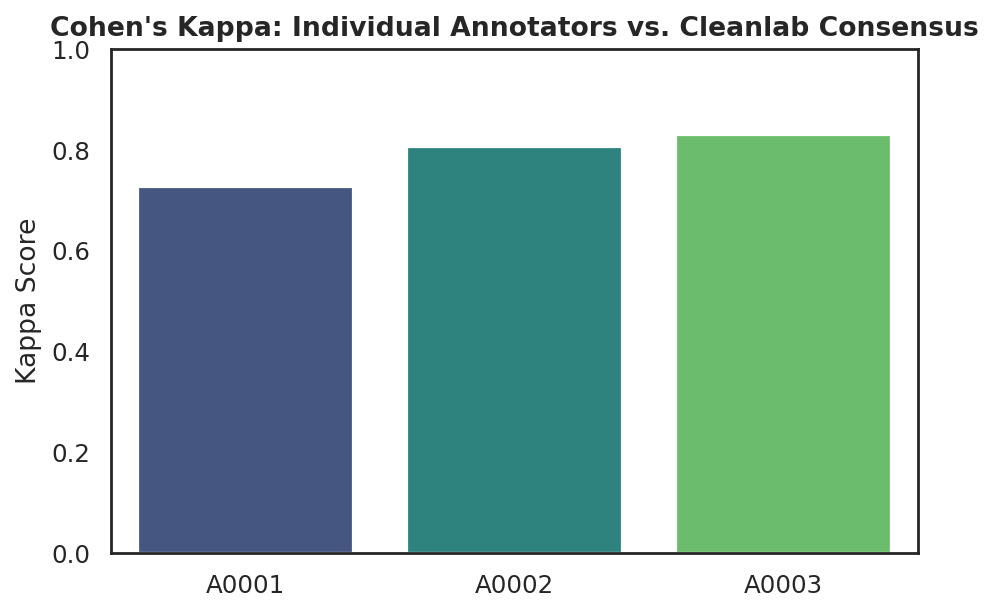

In [ ]:
# Calculate Cohen's Kappa between each annotator and the Cleanlab consensus label
annotator_vs_consensus = {
    'A0001': cohen_kappa_score(cln_combined_df['A0001'], cln_combined_df['consensus_label']),
    'A0002': cohen_kappa_score(cln_combined_df['A0002'], cln_combined_df['consensus_label']),
    'A0003': cohen_kappa_score(cln_combined_df['A0003'], cln_combined_df['consensus_label']),
}

print("\n--- Generating Bar Plot of Annotator vs. Consensus Kappas ---")
# Create the bar plot
plt.figure(figsize=(6, 4))
sns.barplot(x=list(annotator_vs_consensus.keys()), y=list(annotator_vs_consensus.values()), palette='viridis')
plt.title("Cohen's Kappa: Individual Annotators vs. Cleanlab Consensus")
plt.ylim(0, 1) # Set y-axis limit from 0 to 1 for consistent comparison of kappa scores
plt.ylabel("Kappa Score")
plt.tight_layout()
plt.show()

## 4.2 Fleiss' Kappa

### 4.2.1 Compute Fleiss' Kappa
While Cohen's Kappa assesses pairwise agreement, Fleiss' Kappa (κF​) extends this concept to evaluate the overall consistency among all three annotators simultaneously. This metric is particularly useful when there are more than two raters. To compute it, a frequency matrix is constructed, showing how many annotators assigned each category to each item. The resulting Fleiss' Kappa score provides a single measure of collective inter-rater reliability.

In [ ]:
# Extract only the annotator columns for Fleiss' Kappa calculation
selected_kap_clmns = cln_combined_df[['A0001', 'A0002', 'A0003']].values

# Get unique sorted categories from your data (e.g., [0, 1, 2])
categories = sorted(pd.unique(selected_kap_clmns.ravel()))

# Function to count how many annotators chose each category per row
def category_count(row, categories):
    counts = np.zeros(len(categories), dtype=int)
    for i, cat in enumerate(categories):
        counts[i] = np.sum(row == cat)
    return counts

# Build the frequency matrix required for Fleiss' Kappa calculation
# Each row represents an item, and columns represent categories (labels)
frequency_matrix = np.apply_along_axis(category_count, 1, selected_kap_clmns, categories)

# Compute Fleiss' Kappa
fleiss_k = fleiss_kappa(frequency_matrix)

print("--- Computing Fleiss' Kappa ---")
print(f"Fleiss' Kappa (all annotators): {fleiss_k:.3f}")

--- Computing Fleiss' Kappa ---
Fleiss' Kappa (all annotators): 0.608


### 4.2.2 Distribution of Per-Item Annotator Agreement
To provide a visual complement to Fleiss' Kappa and understand the distribution of agreement levels across individual items, a histogram of per-item annotator agreement is generated. For each item, we calculate the proportion of annotators who agreed on the most frequently chosen label. This helps to identify if agreement is consistently high or if there are many items with low consensus, offering insights into the overall consistency of the annotation process at an item level.

[saved] /drive/My Drive/Colab Notebooks/infotracer/RESEARCH/figs_annot/distr_per_item_annot_agree_sent.pdf
[saved] /drive/My Drive/Colab Notebooks/infotracer/RESEARCH/figs_annot/distr_per_item_annot_agree_sent.png


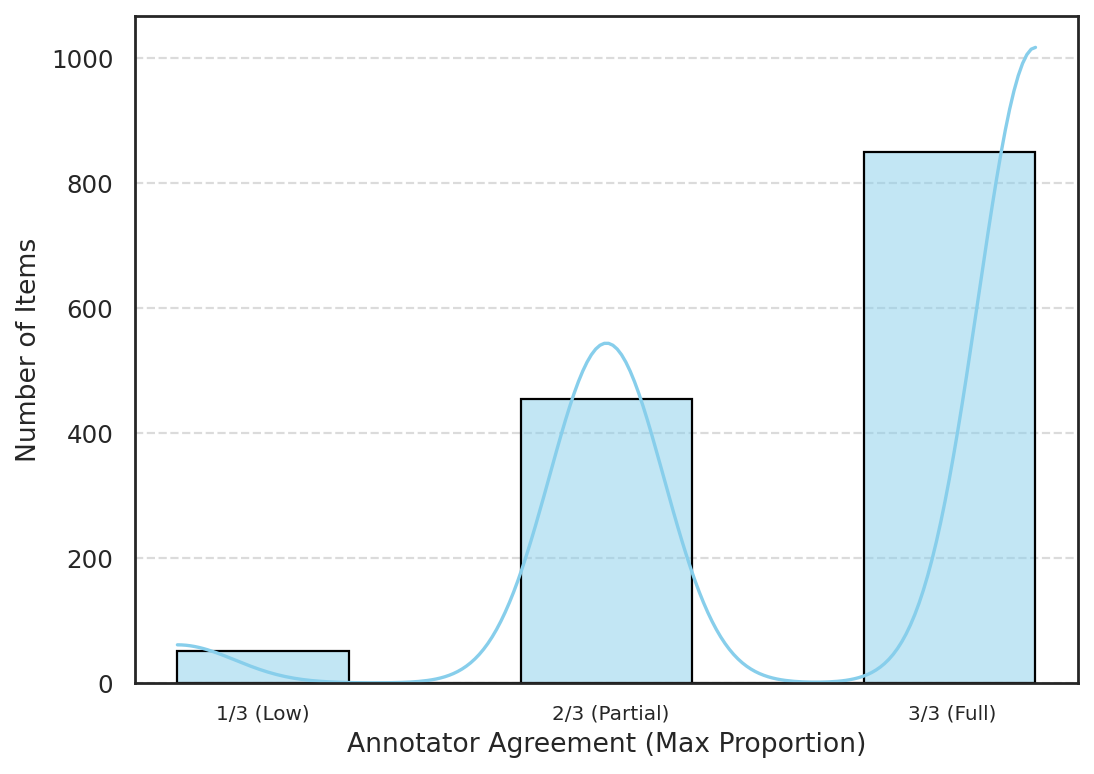

In [ ]:
# Reuse the frequency_matrix computed for Fleiss' Kappa

# Compute per-row agreement score: max count in row / total annotators
# This calculates the proportion of annotators agreeing on the most chosen label for each item
row_agreements = (np.max(frequency_matrix, axis=1) / np.sum(frequency_matrix, axis=1))

#print("\n--- Generating Distribution of Per-Item Annotator Agreement ---")
# Plot histogram of agreement levels
fig = plt.figure(figsize=(7, 5))
sns.histplot(row_agreements, bins=5, kde=True, color='skyblue', edgecolor='black') # Reduced bins for clarity
#plt.title("Distribution of Per-Item Annotator Agreement")
plt.xlabel("Annotator Agreement (Max Proportion)")
plt.ylabel("Number of Items")
plt.xticks([0.4, 0.67, 0.935], ['1/3 (Low)', '2/3 (Partial)', '3/3 (Full)'], fontsize=9) # Custom ticks for 3 annotators
plt.grid(axis='y', linestyle='--', alpha=0.7)

save_figure(fig, f"distr_per_item_annot_agree_sent", subdir=path+"figs_annot/", ext="pdf")
save_figure(fig, f"distr_per_item_annot_agree_sent", subdir=path+"figs_annot/", ext="png")
#sns.despine()
plt.tight_layout()
plt.show()

## 4.3 Summary Table of Inter-Annotator Agreement Metrics
To consolidate the findings from the inter-annotator agreement analysis, a summary table is presented. This table includes the pairwise Cohen's Kappa scores and the overall Fleiss' Kappa score, along with their corresponding qualitative interpretations of agreement levels (e.g., moderate, substantial). This comprehensive overview allows for a quick assessment of the consistency and reliability of the sentiment annotation process across all annotators.


--- Generating Summary Table of Inter-Annotator Agreement ---


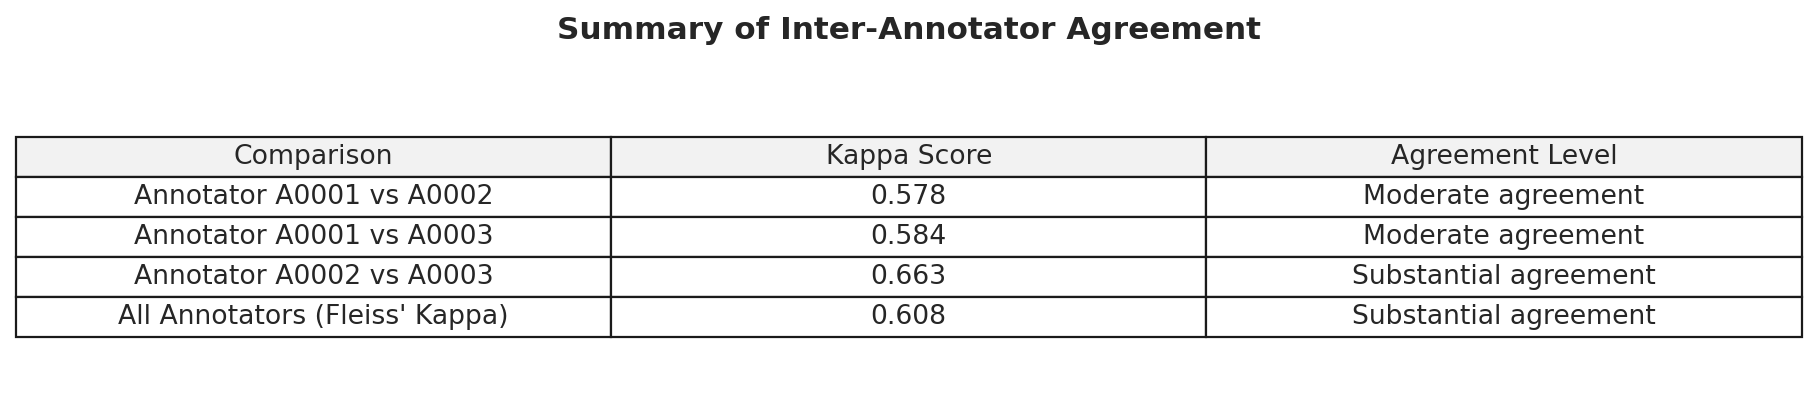

Total items evaluated in cleaned dataset: 1354


In [ ]:
# Prepare the data for the summary table
data = {
    "Comparison": [
        "Annotator A0001 vs A0002",
        "Annotator A0001 vs A0003",
        "Annotator A0002 vs A0003",
        "All Annotators (Fleiss' Kappa)"
    ],
    "Kappa Score": [
        round(cks_1_2, 3),
        round(cks_1_3, 3),
        round(cks_2_3, 3),
        round(fleiss_k, 3)
    ],
    "Agreement Level": [
        "Moderate agreement",
        "Moderate agreement",
        "Substantial agreement",
        "Substantial agreement"
    ]
}

# Create DataFrame for the table
df_results = pd.DataFrame(data)

print("\n--- Generating Summary Table of Inter-Annotator Agreement ---")
# Plot the table using matplotlib
fig, ax = plt.subplots(figsize=(12, 2.5)) # Adjusted figure size for better fit
ax.axis('tight')
ax.axis('off')

# Create the table
table = ax.table(
    cellText=df_results.values,
    colLabels=df_results.columns,
    loc='center',
    cellLoc='center',
    colColours=['#f2f2f2']*len(df_results.columns) # Add light background to column headers
)

# Adjust appearance
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1.2, 1.5) # Adjust cell width and height

# Set title for the table
plt.title("Summary of Inter-Annotator Agreement", fontweight='bold', fontsize=14, pad=20)
plt.show()

# Print total number of items evaluated as context
print(f"Total items evaluated in cleaned dataset: {len(cln_combined_df)}")

# 5.0 Exporting the Final Cleaned Dataset
With the inter-annotator agreement assessed and potential label issues addressed, the final step is to export the cleaned dataset, now enriched with the refined Cleanlab consensus labels. This dataset is ready for subsequent machine learning model training, further analysis, or sharing with other researchers. For organized project management, the output will be saved in the pre-existing data-labeled/data-processed directory. The dataset will be exported in both CSV and Excel formats for broad compatibility.

In [ ]:


# Define the path to the pre-existing output directory
output_dir = path + 'data-labeled/'

# Define the base filename for your cleaned sentiment data
filename_base = 'final-cleaned-sentiment-data'

# --- Option 1: Export to CSV ---
csv_output_path = output_dir + f'{filename_base}.csv'
cln_combined_df.to_csv(csv_output_path, index=False)
print(f"Cleaned dataset successfully exported to: {csv_output_path}")

# --- Option 2: Export to Excel ---
excel_output_path = output_dir + f'{filename_base}.xlsx'
cln_combined_df.to_excel(excel_output_path, index=False)
print(f"Cleaned dataset successfully exported to: {excel_output_path}")

print("\nExport complete. Your cleaned dataset is ready for further use!")

Cleaned dataset successfully exported to: /drive/My Drive/Colab Notebooks/infotracer/RESEARCH/data-labeled/final-cleaned-sentiment-data.csv
Cleaned dataset successfully exported to: /drive/My Drive/Colab Notebooks/infotracer/RESEARCH/data-labeled/final-cleaned-sentiment-data.xlsx

Export complete. Your cleaned dataset is ready for further use!
